## ViT model to ONNX

In [1]:
import transformers
import torch
from transformers import (
    AutoFeatureExtractor, 
    DefaultDataCollator, 
    AutoModelForImageClassification,
    TrainingArguments,
    Trainer
)
extractor = AutoFeatureExtractor.from_pretrained(pretrained_model_name_or_path = 'stochastic/102722run') #this can also be a tokenizer
model = AutoModelForImageClassification.from_pretrained("stochastic/102722run")

In [27]:
from pathlib import Path
import transformers
from transformers.onnx import FeaturesManager
from transformers import AutoConfig, AutoTokenizer, AutoModelForSequenceClassification
#from optimum.onnxruntime.configuration import OptimizationConfig

model_id = "stochastic/102722run"
feature = "image-classification"
model = AutoModelForImageClassification.from_pretrained(model_id)
extractor =  AutoFeatureExtractor.from_pretrained(pretrained_model_name_or_path = 'stochastic/102722run')
#optimization_config = OptimizationConfig(optimization_level=99)

# load config
model_kind, model_onnx_config = FeaturesManager.check_supported_model_or_raise(model, feature=feature)
onnx_config = model_onnx_config(model.config)

# export
onnx_inputs, onnx_outputs = transformers.onnx.export(
        preprocessor=extractor,
        model=model,
        config=onnx_config,
        opset=13,
        output=Path("../../onnx/vit-model.onnx")
)

c:\Users\truon\anaconda3\envs\learn\lib\site-packages\transformers\models\vit\modeling_vit.py:166: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if num_channels != self.num_channels:
c:\Users\truon\anaconda3\envs\learn\lib\site-packages\transformers\models\vit\modeling_vit.py:171: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if height != self.image_size[0] or width != self.image_size[1]:


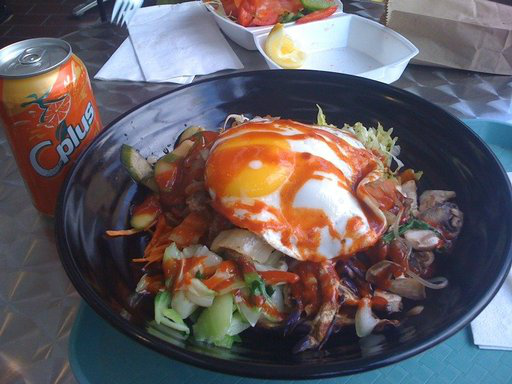

torch.Size([1, 3, 224, 224])


{'pixel_values': tensor([[[[-0.8039, -0.7961, -0.7647,  ..., -0.5686, -0.5608, -0.5765],
          [-0.8039, -0.7961, -0.7647,  ..., -0.5373, -0.5686, -0.5765],
          [-0.7961, -0.7882, -0.7725,  ..., -0.3569, -0.4745, -0.5137],
          ...,
          [-0.3255, -0.3020, -0.3020,  ..., -0.3961, -0.3961, -0.4824],
          [-0.3098, -0.3020, -0.3020,  ..., -0.3804, -0.4275, -0.4980],
          [-0.3176, -0.3020, -0.3176,  ..., -0.3961, -0.4667, -0.4902]],

         [[-0.8196, -0.8039, -0.7725,  ..., -0.6000, -0.5843, -0.6000],
          [-0.8118, -0.8039, -0.7725,  ..., -0.5843, -0.6078, -0.6078],
          [-0.7961, -0.7961, -0.7804,  ..., -0.4275, -0.5451, -0.5765],
          ...,
          [-0.4353, -0.4118, -0.4196,  ...,  0.1059,  0.1216,  0.0588],
          [-0.4196, -0.4196, -0.4196,  ...,  0.1216,  0.0902,  0.0588],
          [-0.4353, -0.4275, -0.4431,  ...,  0.0980,  0.0588,  0.0667]],

         [[-0.7333, -0.7333, -0.7255,  ..., -0.4667, -0.4510, -0.4667],
          [-0

In [28]:
from PIL import Image
image = Image.open(
    '../../data/food-101/images/bibimbap/29190.jpg')
encoding = extractor(image.convert("RGB"), return_tensors="pt")
display(image)
print(encoding.pixel_values.shape)
encoding

In [43]:
from onnxruntime import InferenceSession

session = InferenceSession("../../onnx/vit-model.onnx")
output_name = session.get_outputs()[0].name
input_name = session.get_inputs()[0].name

#onnx expects numpy
inputs = extractor(image.convert("RGB"), return_tensors="np") # lets use one example
outputs = session.run(output_names = [output_name], input_feed=dict(inputs))

outputs[0]
# session.run(None, ort_inputs) 
# or 
# session.run([label_name], {input_name: X_test.astype(numpy.float32)})[0])

array([[-1.49794602e+00,  5.19719720e-02, -1.92465639e+00,
        -8.44135702e-01,  1.30668175e+00, -7.54582822e-01,
        -1.65381837e+00,  8.89418793e+00, -4.39062238e-01,
         2.84847260e+00, -6.57608986e-01, -1.39348209e-01,
        -2.18769264e+00, -4.66941178e-01, -2.65907675e-01,
        -2.80563891e-01, -2.21177173e+00, -1.09810114e+00,
         1.31125569e+00, -4.35711741e-02, -2.98921794e-01,
        -1.03662290e-01, -4.09841388e-01, -2.47576642e+00,
        -7.42997408e-01, -1.37561977e-01, -8.19413900e-01,
        -1.92002678e+00,  2.25395322e+00, -6.93401337e-01,
        -1.12935305e+00, -2.01306295e+00,  1.91473514e-01,
        -3.31914276e-01,  2.40658617e+00,  2.05918461e-01,
         6.84472799e-01,  1.57322657e+00, -1.49417472e+00,
        -1.86927640e+00, -8.65616798e-01, -1.86913466e+00,
        -1.19921243e+00,  6.28860950e-01,  4.26351309e+00,
         1.11832000e-01, -2.84262633e+00,  5.64825475e-01,
        -4.90982056e-01, -2.00988293e+00, -4.53146607e-0

In [47]:
predicted_class_idx = outputs[0].argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])


Predicted class: bibimbap


'bibimbap'

## Flan T5 Model to ONNX
somewhat functional, but most likely a TODO item later 

In [83]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-large")
tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-large")

input_text = f"Answer the following question: What are the textures of curry?"
input_ids = tokenizer(input_text, return_tensors="pt").input_ids

outputs = model.generate(input_ids)
print(tokenizer.decode(outputs.squeeze().tolist(), skip_special_tokens=True))

c:\Users\truon\anaconda3\envs\learn\lib\site-packages\transformers\generation_utils.py:1202: UserWarning: Neither `max_length` nor `max_new_tokens` have been set, `max_length` will default to 20 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


smooth


In [85]:
input_ids.shape

torch.Size([1, 13])

In [91]:
from transformers.models.t5 import T5Config, T5OnnxConfig

# load config
model_id = "google/flan-t5-small"
feature = "seq2seq-lm"

model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-small")
tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-small")

model_kind, model_onnx_config = FeaturesManager.check_supported_model_or_raise(model, feature=feature)
config = T5Config.from_pretrained(model_id)
onnx_config = T5OnnxConfig(config=config, task=feature)

# export
onnx_inputs, onnx_outputs = transformers.onnx.export(
        preprocessor=tokenizer,
        model=model,
        config=onnx_config,
        opset=13,
        output=Path("../../onnx/flan-t5.onnx")
)

c:\Users\truon\anaconda3\envs\learn\lib\site-packages\transformers\modeling_utils.py:679: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if causal_mask.shape[1] < attention_mask.shape[1]:


In [110]:

session = InferenceSession("../../onnx/flan-t5.onnx")
output_name = session.get_outputs()[0].name
input_name = session.get_inputs()[0].name

#onnx expects numpy
dummy_input = onnx_config.generate_dummy_inputs(tokenizer=tokenizer)
outputs = session.run(output_names = [output_name], input_feed=dummy_input)


In [122]:
outputs[0].shape

(2, 8, 32128)

## Optimizations .... for a later time

In [34]:
import onnx

onnx_model = onnx.load("../../onnx/vit-model.onnx")
onnx.checker.check_model(onnx_model)

from transformers.onnx import validate_model_outputs

validate_model_outputs(
    onnx_config, extractor, model_id, '../../onnx/vit-model.onnx', outputs, onnx_config.atol_for_validation
)

In [32]:
# https://www.philschmid.de/optimizing-vision-transformer
# !pip install "optimum[onnxruntime]==1.3.0"  sklearn mkl-include mkl datasets --upgrade
# !pip install git+https://github.com/huggingface/evaluate --upgrade # workaround until image-classification is added


from optimum.onnxruntime import ORTQuantizer
from optimum.onnxruntime.configuration import AutoQuantizationConfig
from optimum.onnxruntime import ORTModelForImageClassification


ImportError: cannot import name 'ORTModelForImageClassification' from 'optimum.onnxruntime' (c:\Users\truon\anaconda3\envs\learn\lib\site-packages\optimum\onnxruntime\__init__.py)